In [95]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from transformers import AdamW
import plotly.express as px

# specify GPU
device = torch.device("cuda")

In [2]:
torch.cuda.is_available()

True

In [3]:
df = pd.read_csv('./df_sep_label_.csv')
df.head()

,sentiment,Классификация по ОКПД2_x,Наименование закупки_x,Реестровый номер закупки,Закупки по,Дата размещения
0,Не подходит,62.01.29.000: Оригиналы программного обеспечен...,Предоставление неисключительного права испол...,№0169300040423000063,44-ФЗ,04.09.2023
1,Подходит,62.09.20.190: Услуги по технической поддержке ...,оказание услуг по обслуживанию и сопровождени...,№0304300010623000024,44-ФЗ,21.09.2023
2,Не подходит,62.02.20.190: Услуги консультативные в области...,Предоставление услуг по сопровождению програм...,№0162300011123000065,44-ФЗ,07.09.2023
3,Не подходит,62.01.29.000: Оригиналы программного обеспечен...,Программное средство антивирусной защиты,№0122100010223000021,44-ФЗ,18.09.2023
4,Не подходит,62.01.29.000: Оригиналы программного обеспечен...,Программное средство антивирусной защиты,№0302300050523000034,44-ФЗ,21.08.2023


In [4]:
df.rename(columns={'Классификация по ОКПД2_x':'okpd_2'},inplace=True)
df.rename(columns={'Наименование закупки_x':'text'},inplace=True)
df.rename(columns={'Реестровый номер закупки':'number'},inplace=True)
df.rename(columns={'Закупки по':'fz'},inplace=True)
df.rename(columns={'Дата размещения':'date'},inplace=True)
df.rename(columns={'sentiment':'label'},inplace=True)

In [5]:
df.head()

,label,okpd_2,text,number,fz,date
0,Не подходит,62.01.29.000: Оригиналы программного обеспечен...,Предоставление неисключительного права испол...,№0169300040423000063,44-ФЗ,04.09.2023
1,Подходит,62.09.20.190: Услуги по технической поддержке ...,оказание услуг по обслуживанию и сопровождени...,№0304300010623000024,44-ФЗ,21.09.2023
2,Не подходит,62.02.20.190: Услуги консультативные в области...,Предоставление услуг по сопровождению програм...,№0162300011123000065,44-ФЗ,07.09.2023
3,Не подходит,62.01.29.000: Оригиналы программного обеспечен...,Программное средство антивирусной защиты,№0122100010223000021,44-ФЗ,18.09.2023
4,Не подходит,62.01.29.000: Оригиналы программного обеспечен...,Программное средство антивирусной защиты,№0302300050523000034,44-ФЗ,21.08.2023


In [6]:
df.isnull().sum()

label     18
okpd_2     2
text       0
number     0
fz         0
date       0
dtype: int64

In [7]:
df.dropna(subset=['label'], inplace=True)
df.dropna(subset=['okpd_2'], inplace=True)

In [8]:
print(df['label'].unique(), len(df['label'].unique()))

['Не подходит' 'Подходит' 'Скорее нет' 'Скорее да' 'Затрудняюсь'] 5


In [9]:
fig = px.histogram(df, x='label')
fig.show()

In [10]:
df.loc[df['label'].isin(['Не подходит', 'Скорее нет', 'Затрудняюсь']), 'label'] = 0
df.loc[df['label'].isin(['Подходит', 'Скорее да']), 'label'] = 1

df.sample(3)

,label,okpd_2,text,number,fz,date
3144,0,62.0: Продукты программные и услуги по разрабо...,Услуги по созданию автоматизированной информац...,№32312650470,223-ФЗ,07.08.2023
201,0,62.02.30.000: Услуги по технической поддержке ...,Выполнение работ по обслуживанию мультимедийно...,№0142200001323021106,44-ФЗ,29.09.2023
1167,0,62.02.30.000: Услуги по технической поддержке ...,Услуги по технической поддержке информационных...,№0262200000123000051,44-ФЗ,29.09.2023


In [11]:
df.shape

(3184, 6)

In [12]:
print(df['label'].unique(), len(df['label'].unique()))

[0 1] 2


In [13]:
fig = px.pie(df, names='label')
fig.show()

Вычислим относительное количество каждого уникального значения в столбце 'label'

In [14]:
df['label'].value_counts(normalize = True)

0    0.924937
1    0.075063
Name: label, dtype: float64

In [15]:
df

,label,okpd_2,text,number,fz,date
0,0,62.01.29.000: Оригиналы программного обеспечен...,Предоставление неисключительного права испол...,№0169300040423000063,44-ФЗ,04.09.2023
1,1,62.09.20.190: Услуги по технической поддержке ...,оказание услуг по обслуживанию и сопровождени...,№0304300010623000024,44-ФЗ,21.09.2023
2,0,62.02.20.190: Услуги консультативные в области...,Предоставление услуг по сопровождению програм...,№0162300011123000065,44-ФЗ,07.09.2023
3,0,62.01.29.000: Оригиналы программного обеспечен...,Программное средство антивирусной защиты,№0122100010223000021,44-ФЗ,18.09.2023
4,0,62.01.29.000: Оригиналы программного обеспечен...,Программное средство антивирусной защиты,№0302300050523000034,44-ФЗ,21.08.2023
...,...,...,...,...,...,...
3199,0,62.02.30.000: Услуги по технической поддержке ...,"Оказание услуг по восстановлению, обновлению п...",№32312635470,223-ФЗ,01.08.2023
3200,0,62.02.30.000: Услуги по технической поддержке ...,Оказание услуг по обслуживанию программы 1С:Бу...,№32312635242,223-ФЗ,01.08.2023
3201,0,62.03.12.130: Услуги по сопровождению компьюте...,Услуги по адаптации и сопровождению экземпляро...,№32312634646,223-ФЗ,01.08.2023
3202,0,62.09.2: Услуги в области информационных техно...,Предоставление права использования программы д...,№32312634315,223-ФЗ,01.08.2023


In [16]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2024, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2024, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [17]:
print('размер train_text', train_text.shape)
print('размер temp_text', temp_text.shape)

print('размер val_text', val_text.shape)
print('размер test_text', test_text.shape)

размер train_text (2228,)
размер temp_text (956,)
размер val_text (478,)
размер test_text (478,)


Существует четыре типа предварительно обученных версий BERT в зависимости от масштаба архитектуры модели:

BERT-Base (Cased / Un-Cased): 12-слойная, 768 скрытых узлов, 12 головок внимания, 110M параметров.\
BERT-Large (Cased / Un-Cased): 24 слоя, 1024 скрытых узла, 16 головок внимания, 340 М параметров.

Нам нужно выбрать, какие предварительно обученные веса BERT нам нужны. Например, если у нас нет доступа к Google TPU, мы предпочтем использовать модели Base. А выбор "с корпусом" и "без корпуса" зависит от того, будет ли, по нашему мнению, корпус букв полезен для решения поставленной задачи.

Переведено с помощью www.DeepL.com/Translator (бесплатная версия)

In [18]:
# tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")
# bert = AutoModel.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")


tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
bert = AutoModel.from_pretrained("ai-forever/ruBert-base")


# bert = AutoModel.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

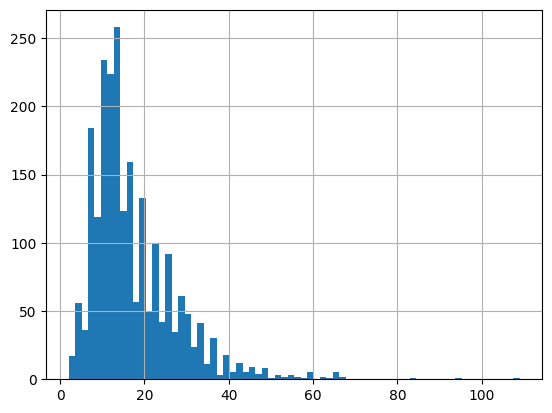

In [19]:
# получим длину всех сообщений в обучающем наборе

seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 70)

In [20]:
# токенизируем и кодируем последовательности в train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    padding='longest',
    truncation=True
)

# токенизируем и кодируем последовательности в validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    padding='longest',
    truncation=True
)

# токенизируем и кодируем последовательности в test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    padding='longest',
    truncation=True
)

In [21]:
## преобразование списков в тензоры

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

Data Loader

In [22]:
# определяем batch size
batch_size = 32

# разворачиваем TensorDataset для train_data
train_data = TensorDataset(train_seq, train_mask, train_y)

# сэмплер для выборки train_data
train_sampler = RandomSampler(train_data)

# dataLoader для тренировочного set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# разворачиваем TensorDataset для val_data
val_data = TensorDataset(val_seq, val_mask, val_y)

# сэмплер для выборки val_data
val_sampler = SequentialSampler(val_data)

# dataLoader для валидационного set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

Model Architecture

In [23]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [24]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [25]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [26]:
optimizer = AdamW(model.parameters(),lr = 1e-5) 

c:\Users\Mi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:429: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Для учета дисбаланса классов применяем class_weights

In [27]:
#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:",class_weights)

Class Weights: [0.54051431 6.67065868]


In [28]:
# преобразование списка весов классов в тензор
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# определяем функцию потерь
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

Fine - Tune

In [29]:
# функция для обучения модели
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [30]:
# функция для оценки модели
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

- set initial loss to infinite \
Установка начальной потери на бесконечность гарантирует, что модель будет стремиться улучшиться в процессе обучения.

Это также может помочь избежать проблемы, когда модель останавливается на локальном минимуме потерь и не может дальше улучшаться. Установка начальной потери на бесконечность может помочь модели избежать этой проблемы и достигнуть лучшего результата.

In [31]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.680
Validation Loss: 0.673

 Epoch 2 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.670
Validation Loss: 0.662

 Epoch 3 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.657
Validation Loss: 0.653

 Epoch 4 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.642
Validation Loss: 0.641

 Epoch 5 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.632
Validation Loss: 0.630

 Epoch 6 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.618
Validation Loss: 0.616

 Epoch 7 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.608
Validation Loss: 0.606

 Epoch 8 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.602
Validation Loss: 0.597

 Epoch 9 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.588
Validation Loss: 0.587

 Epoch 10 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.584
Validation L

In [32]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

--------------------
делаем  Predictions

In [33]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [34]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       442
           1       0.22      0.56      0.32        36

    accuracy                           0.82       478
   macro avg       0.59      0.70      0.61       478
weighted avg       0.90      0.82      0.85       478



`support`  в отчете о классификации (classification report) представляет собой количество истинных меток для каждого класса в данных. 

In [35]:
podhodit = '''
№ 101 Оказание услуг по сопровождению Государственной информационной системы Удмуртской Республики «Управление финансово-экономической деятельностью государственных органов Удмуртской Республики, органов местного самоуправления в Удмуртской Республике и подведомственных им учреждений» для нужд автономного учреждения «Центр цифровых технологий Удмуртской Республики»
'''

__________________________________


In [149]:
train_mask.shape

torch.Size([2228, 25])

In [150]:
test_mask.shape

torch.Size([478, 25])

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [162]:
X_tensor.shape[1]

25

In [160]:
y_tensor.shape[0]

25

In [ ]:
train_mask = torch.tensor(tokens_train['attention_mask'])
test_mask = torch.tensor(tokens_test['attention_mask'])
val_mask = torch.tensor(tokens_val['attention_mask'])

In [172]:
# Преобразование массива выходных данных к одинаковым размерам
# Создание новых массивов входных и выходных данных
X_tensor = train_mask.reshape(-1, train_mask.shape[1])
y_tensor = test_mask.reshape(-1, test_mask.shape[0])


# Assuming X_tensor has shape (25, 2228) and y_tensor has shape (478,)
X_tensor = X_tensor.reshape(1, -1)  # Reshape X_tensor to have shape (1, 478 * 2228)
X_tensor = X_tensor.float()
y_tensor = y_tensor.reshape(-1, 1)  # Reshape y_tensor to have shape (478, 1)


class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, X):
        predictions = self.linear(X)
        return torch.sigmoid(predictions)

model = LogisticRegressionTorch(X_tensor.shape[1], y_tensor.shape[0])

epochs = 1000
learning_rate = 0.001

# определяем функцию потерь — бинарную кросс-энтропию
criterion = nn.BCELoss()

# определяем алгоритм оптимизации Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(X_tensor.float())
    loss = criterion(predictions, y_tensor)
    # вычисляем градиенты
    loss.backward()
    # обновляем параметры
    optimizer.step()
# проверяем на словаре

predictions = model(X_tensor.float())
print(roc_auc_score(test_labels, predictions.detach().numpy()))

ValueError: Using a target size (torch.Size([11950, 1])) that is different to the input size (torch.Size([1, 11950])) is deprecated. Please ensure they have the same size.

In [145]:
predictions.shape

torch.Size([25, 2228])

In [147]:
y_tensor.shape

torch.Size([2228, 1])

In [161]:
X_tensor = train_mask.reshape(-1, train_mask.shape[1])
y_tensor = test_mask.reshape(-1, test_mask.shape[0])

In [158]:
X_tensor.T.shape

torch.Size([25, 2228])

In [156]:
y_tensor.shape

torch.Size([25, 478])